# 股价预测专题

In [1]:
# 必要的库
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler  # 进行归一化操作

# 自行编写的包
sys.path.append('/home/ubuntu/notebooks/pycharm_projects/Investor-Sentiment')


2023-03-11 17:03:28.792299: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 数据准备

### 参数区

In [2]:
# 特征工程和数据集
# factor_column = ['close', 'img_neg', 'tex_neg', 'SENT_INDEX', 'SENT_INDEX_R']
factor_column = ['close']
df_data = pd.read_csv('/data/DataSets/investor_sentiment/FINAL_DATA_2014_2021.csv', usecols=factor_column)

# 参数区
TIME_STEPS = 30  # 时间窗
BATCH_SIZE = 1024
EPOCHS = 100
amount_of_features = len(factor_column)  # 特征
train_size, val_size = int(len(df_data) * 0.6), int(len(df_data) * 0.8)  #训练集,测试集

### 数据集转换

In [3]:
# 归一化 将数据缩放到 [0, 1] 范围内
Scaler = MinMaxScaler()
df_std = Scaler.fit_transform(df_data)

# 将数据集分为训练集,验证集和测试集
train_data, val_data, test_data = df_std[0:train_size, :], df_std[train_size:val_size, :], df_std[val_size:, :]


# 将时间序列数据转换为监督学习数据
def create_dataset(dataset, look_back):
    samples, labels = [], []
    for i in range(look_back, len(dataset)):
        samples.append(dataset[i - look_back:i])
        labels.append(dataset[i, -1])
    return np.array(samples), np.array(labels)


# 生成训练集和测试集
train_X, train_Y = create_dataset(train_data, TIME_STEPS)
val_X, val_Y = create_dataset(val_data, TIME_STEPS)
test_X, test_Y = create_dataset(test_data, TIME_STEPS)
train_X.shape, val_X.shape, test_X.shape  # [样本数, 时间步数, 特征数]

((1136, 30, 1), (359, 30, 1), (359, 30, 1))

## 模型构建

In [4]:
# 构建LSTM模型
model = Sequential([
        LSTM(units=64, input_shape=(TIME_STEPS, amount_of_features), return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64),
        Dropout(0.2),
        Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')
model.summary()

2023-03-11 17:03:30.151243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 17:03:30.159669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 17:03:30.161276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 17:03:30.163027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

## 模型训练

In [5]:
# 训练模型
history = model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_Y))

Epoch 1/100


2023-03-11 17:03:36.893349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/miniconda3/envs/Rapids/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasGetSmCountTarget


2/2 [==============================] - 6s 1s/step - loss: 0.1456 - val_loss: 0.0285
Epoch 2/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0550 - val_loss: 0.0089
Epoch 3/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0167 - val_loss: 0.0177
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0220 - val_loss: 0.0016
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0115 - val_loss: 0.0054
Epoch 6/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0203 - val_loss: 0.0050
Epoch 7/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0187 - val_loss: 0.0019
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0115 - val_loss: 0.0034
Epoch 9/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 10/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 11/100
2/2 [===============

12/12 [==============================] - 1s 3ms/step


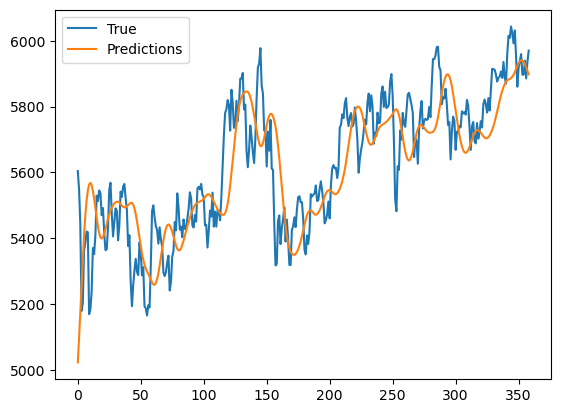

In [6]:
# 预测
pred_Y = model.predict(test_X)

# 反缩放预测结果
pred_Y_sc = Scaler.inverse_transform(pred_Y.reshape(-1, 1))
test_Y_sc = Scaler.inverse_transform(test_Y.reshape(-1, 1))

plt.plot(test_Y_sc, label='True')
plt.plot(pred_Y_sc, label='Predictions')
plt.legend()